In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
zip_path = '/content/drive/MyDrive/archive (4).zip'
extract_path = '/content/extracted_files'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


KeyboardInterrupt: 

In [ ]:
import os

extract_path = '/content/extracted_files'  # Same as before

for root, dirs, files in os.walk(extract_path):
    for file in files:
        print(os.path.join(root, file))


/content/extracted_files/split_50_50/test/Black Rot/aug_72.jpg
/content/extracted_files/split_50_50/test/Black Rot/orig_21.jpeg
/content/extracted_files/split_50_50/test/Black Rot/aug_98.jpg
/content/extracted_files/split_50_50/test/Black Rot/orig_92.jpg
/content/extracted_files/split_50_50/test/Black Rot/orig_86.jpg
/content/extracted_files/split_50_50/test/Black Rot/aug_58.jpg
/content/extracted_files/split_50_50/test/Black Rot/orig_54.jpeg
/content/extracted_files/split_50_50/test/Black Rot/orig_37.jpg
/content/extracted_files/split_50_50/test/Black Rot/orig_35.jpeg
/content/extracted_files/split_50_50/test/Black Rot/orig_94.jpeg
/content/extracted_files/split_50_50/test/Black Rot/aug_15.jpg
/content/extracted_files/split_50_50/test/Black Rot/aug_55.jpg
/content/extracted_files/split_50_50/test/Black Rot/aug_50.jpg
/content/extracted_files/split_50_50/test/Black Rot/aug_68.jpg
/content/extracted_files/split_50_50/test/Black Rot/orig_4.jpeg
/content/extracted_files/split_50_50/test/B

In [ ]:
import os

def print_folder_structure_with_counts(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        level = dirpath.replace(root_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(dirpath)}/ ({len(filenames)} files)")

extract_path = '/content/extracted_files'

print_folder_structure_with_counts(extract_path)


extracted_files/ (0 files)
    split_50_50/ (0 files)
        test/ (0 files)
            Black Rot/ (100 files)
            No disease/ (100 files)
            Alternaria_Leaf_Spot/ (100 files)
            Downy Mildew/ (100 files)
            club root/ (100 files)
            ring spot/ (100 files)
            Bacterial spot rot/ (100 files)
            Cabbage aphid colony/ (100 files)
        train/ (0 files)
            Black Rot/ (100 files)
            No disease/ (100 files)
            Alternaria_Leaf_Spot/ (100 files)
            Downy Mildew/ (100 files)
            club root/ (100 files)
            ring spot/ (100 files)
            Bacterial spot rot/ (100 files)
            Cabbage aphid colony/ (100 files)
    split_60_40/ (0 files)
        test/ (0 files)
            Black Rot/ (80 files)
            No disease/ (80 files)
            Alternaria_Leaf_Spot/ (80 files)
            Downy Mildew/ (80 files)
            club root/ (80 files)
            ring spot/ (80 file

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import layers, models
import os
import numpy as np
from sklearn.metrics import f1_score

# Define dataset paths (adjust if needed)
base_dir = "/content/extracted_files/split_50_50"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "test")

# Parameters
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32
NUM_CLASSES = 8  # Update this if your dataset has different number of classes

# Data Generators with augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load InceptionV3 base model without top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))
base_model.trainable = False

# Build your model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile model with metrics including Precision and Recall
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Custom callback to compute F1-score at epoch end
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_preds = []
        val_trues = []
        for i in range(len(val_generator)):
            x_val, y_val = val_generator[i]
            preds = model.predict(x_val)
            val_preds.extend(np.argmax(preds, axis=1))
            val_trues.extend(np.argmax(y_val, axis=1))
        f1 = f1_score(val_trues, val_preds, average='weighted')
        print(f" — val_f1: {f1:.4f}")

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[F1ScoreCallback()]
)


FileNotFoundError: [Errno 2] No such file or directory: '/content/extracted_files/split_50_50/train'

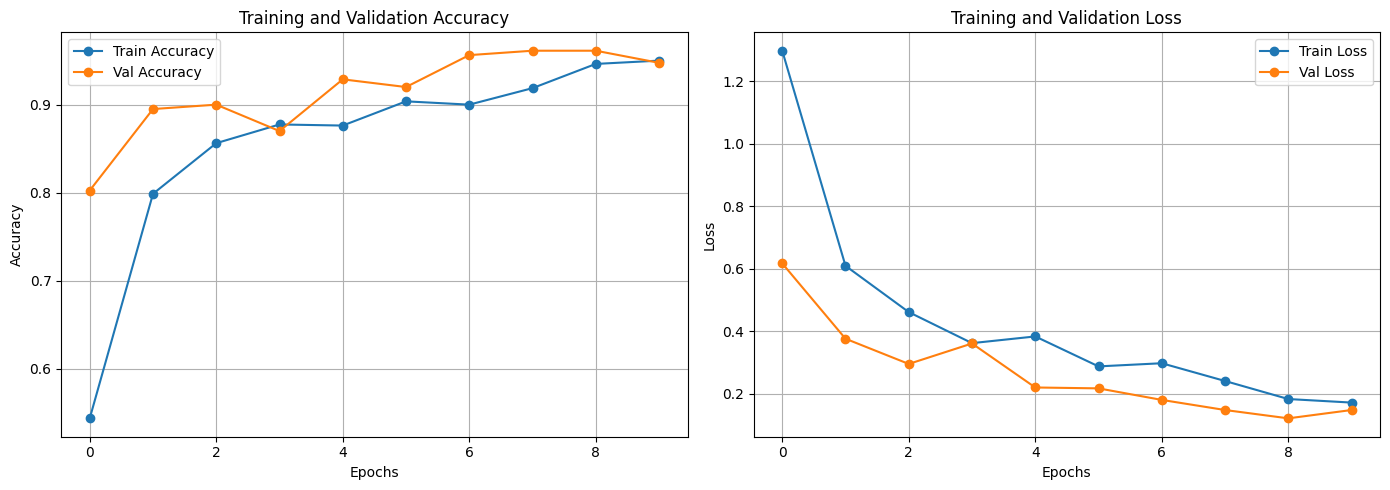

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Val Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Val Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_generator)

print("\n✅ Final Evaluation Metrics:")
print(f"Validation Accuracy : {val_accuracy * 100:.2f}%")
print(f"Validation Loss     : {val_loss:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall   : {val_recall:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9070 - loss: 0.2364 - precision: 0.9139 - recall: 0.9042

✅ Final Evaluation Metrics:
Validation Accuracy : 94.75%
Validation Loss     : 0.1481
Validation Precision: 0.9497
Validation Recall   : 0.9450


25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step


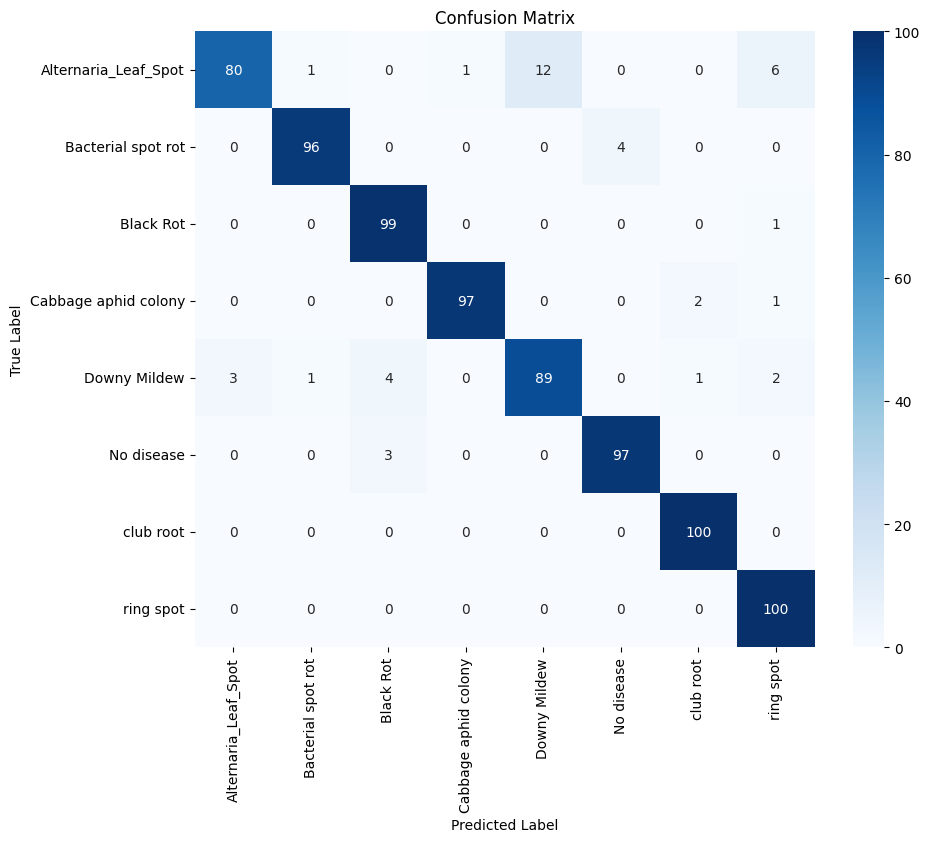


🧾 Classification Report:
                      precision    recall  f1-score   support

Alternaria_Leaf_Spot       0.96      0.80      0.87       100
  Bacterial spot rot       0.98      0.96      0.97       100
           Black Rot       0.93      0.99      0.96       100
Cabbage aphid colony       0.99      0.97      0.98       100
        Downy Mildew       0.88      0.89      0.89       100
          No disease       0.96      0.97      0.97       100
           club root       0.97      1.00      0.99       100
           ring spot       0.91      1.00      0.95       100

            accuracy                           0.95       800
           macro avg       0.95      0.95      0.95       800
        weighted avg       0.95      0.95      0.95       800



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# ✅ Class labels from validation generator
class_labels = list(val_generator.class_indices.keys())

# ✅ Function to predict and visualize one image
def predict_single_image(img_path, model, class_labels):
    try:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make prediction
        preds = model.predict(img_array)
        predicted_index = np.argmax(preds)
        predicted_class = class_labels[predicted_index]
        confidence = preds[0][predicted_index]

        # Show image and prediction
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")
        plt.show()

        print(f"✅ Predicted class: {predicted_class}")
        print(f"📊 Confidence: {confidence * 100:.2f}%")

    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


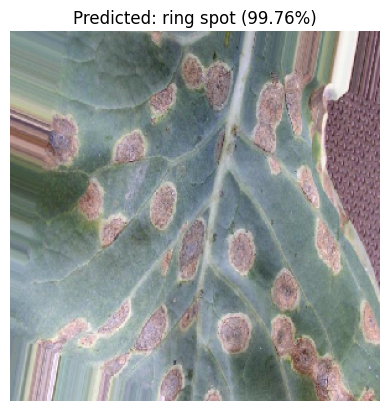

✅ Predicted class: ring spot
📊 Confidence: 99.76%


In [ ]:
# 🔍 Run prediction on a test image
predict_single_image(
    "/content/extracted_files/split_50_50/test/ring spot/orig_83.jpg",  # Update path to your image
    model,
    class_labels
)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# === 1. Final Training & Validation Accuracy from History ===
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(" === Final Accuracy Summary ===")
print(f"Training Accuracy   : {final_train_acc * 100:.2f}%")
print(f"Validation Accuracy : {final_val_acc * 100:.2f}%")

# === 2. Predictions on Test (Validation) Set ===
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# === 3. Final Metrics ===
test_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n === Final Test Evaluation Metrics ===")
print(f"Test Accuracy       : {test_accuracy * 100:.2f}%")
print(f"Precision           : {precision * 100:.2f}%")
print(f"Recall              : {recall * 100:.2f}%")
print(f"F1 Score            : {f1 * 100:.2f}%")


 === Final Accuracy Summary ===
Training Accuracy   : 95.00%
Validation Accuracy : 94.75%

 === Final Test Evaluation Metrics ===
Test Accuracy       : 94.75%
Precision           : 94.86%
Recall              : 94.75%
F1 Score            : 94.67%


In [ ]:
# Save the trained model
model.save("model.h5")
print("✅ Model saved as model.h5")


✅ Model saved as model.h5


cauli7030

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import layers, models
import os
import numpy as np
from sklearn.metrics import f1_score

# Define dataset paths (adjust if needed)
base_dir = "/content/extracted_files/split_70_30"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "test")

# Parameters
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32
NUM_CLASSES = 8  # Update this if your dataset has different number of classes

# Data Generators with augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load InceptionV3 base model without top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))
base_model.trainable = False

# Build your model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile model with metrics including Precision and Recall
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Custom callback to compute F1-score at epoch end
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_preds = []
        val_trues = []
        for i in range(len(val_generator)):
            x_val, y_val = val_generator[i]
            preds = model.predict(x_val)
            val_preds.extend(np.argmax(preds, axis=1))
            val_trues.extend(np.argmax(y_val, axis=1))
        f1 = f1_score(val_trues, val_preds, average='weighted')
        print(f" — val_f1: {f1:.4f}")

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[F1ScoreCallback()]
)


Found 1120 images belonging to 8 classes.
Found 480 images belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
 — val_f1: 0.8157
35/35 ━━━━━━━━━━━━━━━━━━━━ 172s 5s/step - accuracy: 0.3829 - loss: 1.7270 - precision: 0.5549 - recall: 0.2491 - val_accuracy: 0.8188 - val_loss: 0.5682 - val_precision: 0.9074 - val_recall: 0.7146
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

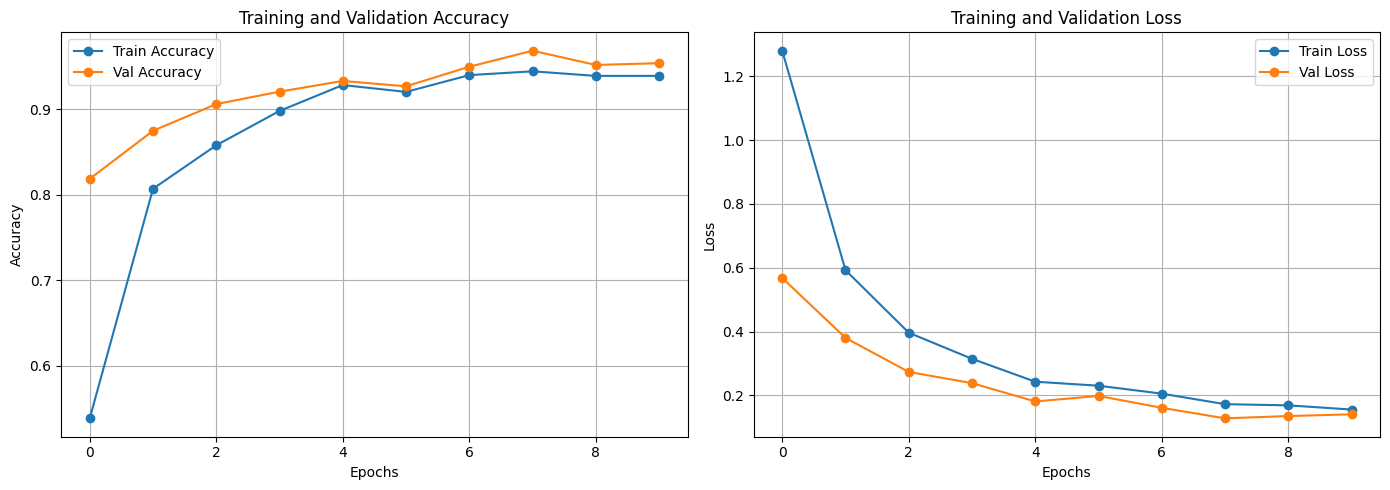

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Val Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Val Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_generator)

print("\n✅ Final Evaluation Metrics:")
print(f"Validation Accuracy : {val_accuracy * 100:.2f}%")
print(f"Validation Loss     : {val_loss:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall   : {val_recall:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9532 - loss: 0.1426 - precision: 0.9552 - recall: 0.9482

✅ Final Evaluation Metrics:
Validation Accuracy : 95.42%
Validation Loss     : 0.1410
Validation Precision: 0.9580
Validation Recall   : 0.9500


15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step


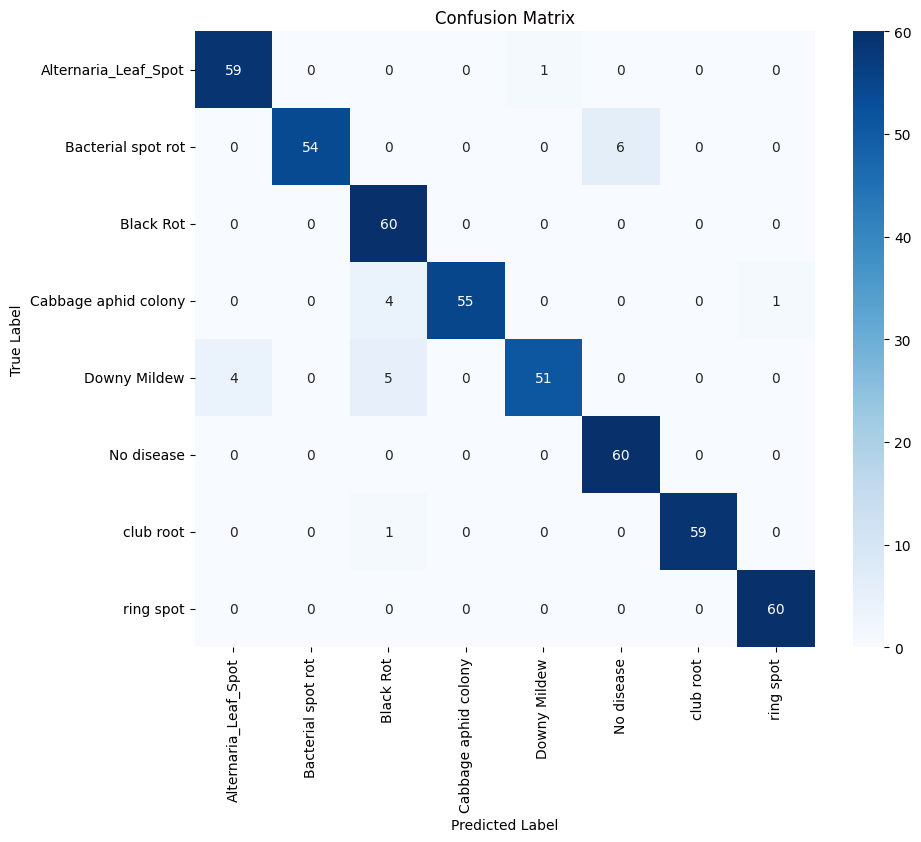


🧾 Classification Report:
                      precision    recall  f1-score   support

Alternaria_Leaf_Spot       0.94      0.98      0.96        60
  Bacterial spot rot       1.00      0.90      0.95        60
           Black Rot       0.86      1.00      0.92        60
Cabbage aphid colony       1.00      0.92      0.96        60
        Downy Mildew       0.98      0.85      0.91        60
          No disease       0.91      1.00      0.95        60
           club root       1.00      0.98      0.99        60
           ring spot       0.98      1.00      0.99        60

            accuracy                           0.95       480
           macro avg       0.96      0.95      0.95       480
        weighted avg       0.96      0.95      0.95       480



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# ✅ Class labels from validation generator
class_labels = list(val_generator.class_indices.keys())

# ✅ Function to predict and visualize one image
def predict_single_image(img_path, model, class_labels):
    try:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make prediction
        preds = model.predict(img_array)
        predicted_index = np.argmax(preds)
        predicted_class = class_labels[predicted_index]
        confidence = preds[0][predicted_index]

        # Show image and prediction
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")
        plt.show()

        print(f"✅ Predicted class: {predicted_class}")
        print(f"📊 Confidence: {confidence * 100:.2f}%")

    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


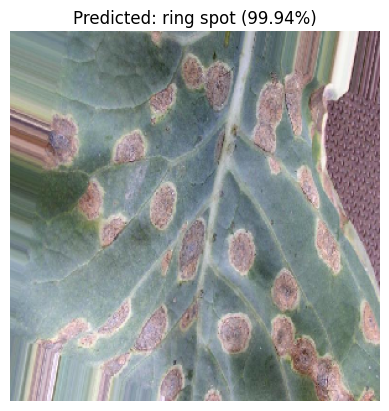

✅ Predicted class: ring spot
📊 Confidence: 99.94%


In [ ]:
# 🔍 Run prediction on a test image
predict_single_image(
    "/content/extracted_files/split_50_50/test/ring spot/orig_83.jpg",  # Update path to your image
    model,
    class_labels
)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# === 1. Final Training & Validation Accuracy from History ===
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(" === Final Accuracy Summary ===")
print(f"Training Accuracy   : {final_train_acc * 100:.2f}%")
print(f"Validation Accuracy : {final_val_acc * 100:.2f}%")

# === 2. Predictions on Test (Validation) Set ===
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# === 3. Final Metrics ===
test_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n === Final Test Evaluation Metrics ===")
print(f"Test Accuracy       : {test_accuracy * 100:.2f}%")
print(f"Precision           : {precision * 100:.2f}%")
print(f"Recall              : {recall * 100:.2f}%")
print(f"F1 Score            : {f1 * 100:.2f}%")


 === Final Accuracy Summary ===
Training Accuracy   : 93.93%
Validation Accuracy : 95.42%

 === Final Test Evaluation Metrics ===
Test Accuracy       : 95.42%
Precision           : 95.84%
Recall              : 95.42%
F1 Score            : 95.41%


In [ ]:
# Save the trained model
model.save("model1.h5")
print("✅ Model saved as model1.h5")

✅ Model saved as model1.h5


cauli8020

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import layers, models
import os
import numpy as np
from sklearn.metrics import f1_score

# Define dataset paths (adjust if needed)
base_dir = "/content/extracted_files/split_80_20"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "test")

# Parameters
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32
NUM_CLASSES = 8  # Update this if your dataset has different number of classes

# Data Generators with augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load InceptionV3 base model without top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))
base_model.trainable = False

# Build your model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile model with metrics including Precision and Recall
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Custom callback to compute F1-score at epoch end
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_preds = []
        val_trues = []
        for i in range(len(val_generator)):
            x_val, y_val = val_generator[i]
            preds = model.predict(x_val)
            val_preds.extend(np.argmax(preds, axis=1))
            val_trues.extend(np.argmax(y_val, axis=1))
        f1 = f1_score(val_trues, val_preds, average='weighted')
        print(f" — val_f1: {f1:.4f}")

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[F1ScoreCallback()]
)


Found 1280 images belonging to 8 classes.
Found 320 images belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
 — val_f1: 0.8564
40/40 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.4103 - loss: 1.6532 - precision: 0.6213 - recall: 0.2533 - val_accuracy: 0.8562 - val_loss: 0.5252 - val_precision: 0.9091 - val_recall: 0.7500
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

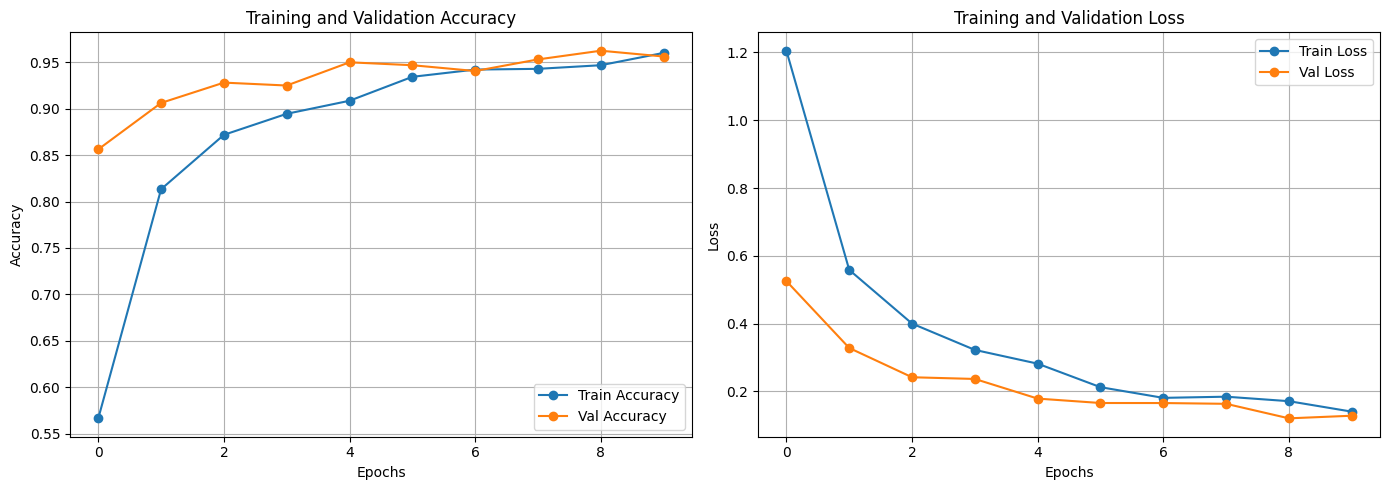

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Val Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Val Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_generator)

print("\n✅ Final Evaluation Metrics:")
print(f"Validation Accuracy : {val_accuracy * 100:.2f}%")
print(f"Validation Loss     : {val_loss:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall   : {val_recall:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9514 - loss: 0.1534 - precision: 0.9569 - recall: 0.9509

✅ Final Evaluation Metrics:
Validation Accuracy : 95.63%
Validation Loss     : 0.1278
Validation Precision: 0.9591
Validation Recall   : 0.9531


10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step


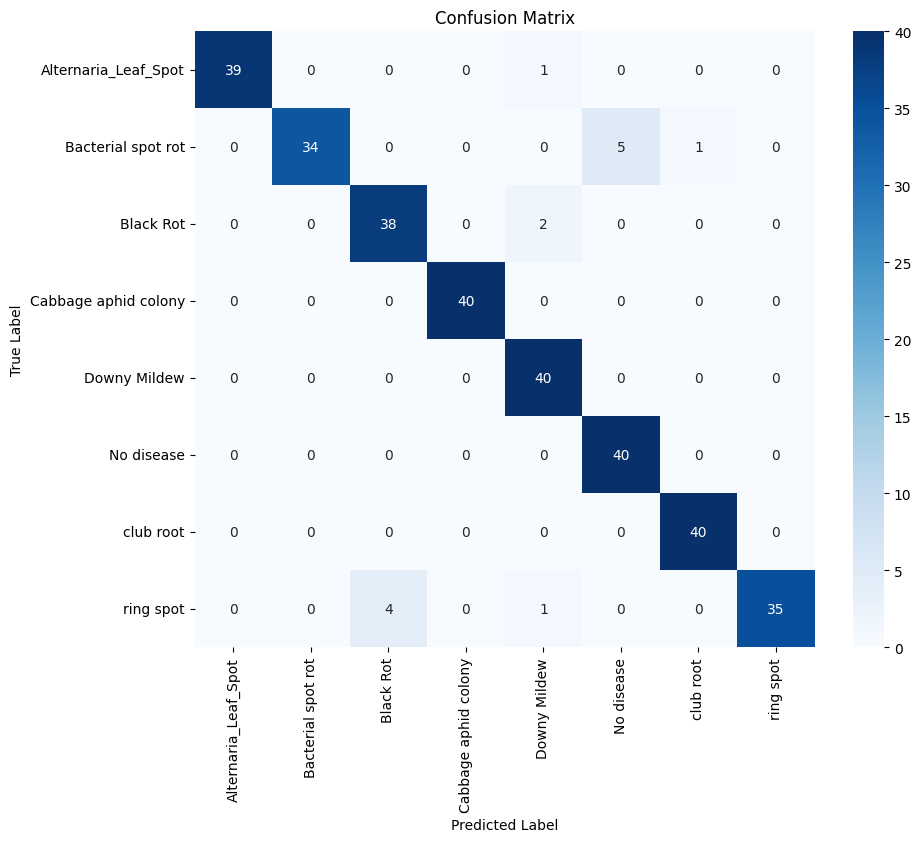


🧾 Classification Report:
                      precision    recall  f1-score   support

Alternaria_Leaf_Spot       1.00      0.97      0.99        40
  Bacterial spot rot       1.00      0.85      0.92        40
           Black Rot       0.90      0.95      0.93        40
Cabbage aphid colony       1.00      1.00      1.00        40
        Downy Mildew       0.91      1.00      0.95        40
          No disease       0.89      1.00      0.94        40
           club root       0.98      1.00      0.99        40
           ring spot       1.00      0.88      0.93        40

            accuracy                           0.96       320
           macro avg       0.96      0.96      0.96       320
        weighted avg       0.96      0.96      0.96       320



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# ✅ Class labels from validation generator
class_labels = list(val_generator.class_indices.keys())

# ✅ Function to predict and visualize one image
def predict_single_image(img_path, model, class_labels):
    try:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make prediction
        preds = model.predict(img_array)
        predicted_index = np.argmax(preds)
        predicted_class = class_labels[predicted_index]
        confidence = preds[0][predicted_index]

        # Show image and prediction
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")
        plt.show()

        print(f"✅ Predicted class: {predicted_class}")
        print(f"📊 Confidence: {confidence * 100:.2f}%")

    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


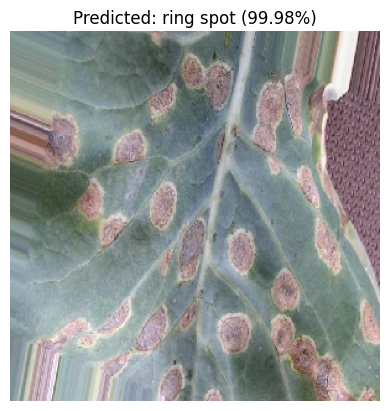

✅ Predicted class: ring spot
📊 Confidence: 99.98%


In [ ]:
# 🔍 Run prediction on a test image
predict_single_image(
    "/content/extracted_files/split_50_50/test/ring spot/orig_83.jpg",  # Update path to your image
    model,
    class_labels
)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# === 1. Final Training & Validation Accuracy from History ===
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(" === Final Accuracy Summary ===")
print(f"Training Accuracy   : {final_train_acc * 100:.2f}%")
print(f"Validation Accuracy : {final_val_acc * 100:.2f}%")

# === 2. Predictions on Test (Validation) Set ===
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# === 3. Final Metrics ===
test_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n === Final Test Evaluation Metrics ===")
print(f"Test Accuracy       : {test_accuracy * 100:.2f}%")
print(f"Precision           : {precision * 100:.2f}%")
print(f"Recall              : {recall * 100:.2f}%")
print(f"F1 Score            : {f1 * 100:.2f}%")


 === Final Accuracy Summary ===
Training Accuracy   : 96.02%
Validation Accuracy : 95.63%

 === Final Test Evaluation Metrics ===
Test Accuracy       : 95.62%
Precision           : 95.98%
Recall              : 95.62%
F1 Score            : 95.60%


In [ ]:
# Save the trained model
model.save("model03.h5")
print("✅ Model saved as model03.h5")

✅ Model saved as model03.h5


cauli6040

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import layers, models
import os
import numpy as np
from sklearn.metrics import f1_score

# Define dataset paths (adjust if needed)
base_dir = "/content/extracted_files/split_60_40"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "test")

# Parameters
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32
NUM_CLASSES = 8  # Update this if your dataset has different number of classes

# Data Generators with augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load InceptionV3 base model without top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))
base_model.trainable = False

# Build your model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile model with metrics including Precision and Recall
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Custom callback to compute F1-score at epoch end
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_preds = []
        val_trues = []
        for i in range(len(val_generator)):
            x_val, y_val = val_generator[i]
            preds = model.predict(x_val)
            val_preds.extend(np.argmax(preds, axis=1))
            val_trues.extend(np.argmax(y_val, axis=1))
        f1 = f1_score(val_trues, val_preds, average='weighted')
        print(f" — val_f1: {f1:.4f}")

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[F1ScoreCallback()]
)


Found 960 images belonging to 8 classes.
Found 640 images belonging to 8 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
 — val_f1: 0.7775
30/30 ━━━━━━━━━━━━━━━━━━━━ 780s 26s/step - accuracy: 0.4057 - loss: 1.6635 - precision: 0.5551 - recall: 0.2084 - val_accuracy: 0.7844 - val_loss: 0.6789 - val_precision: 0.8452 - val_recall: 0.6484
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step

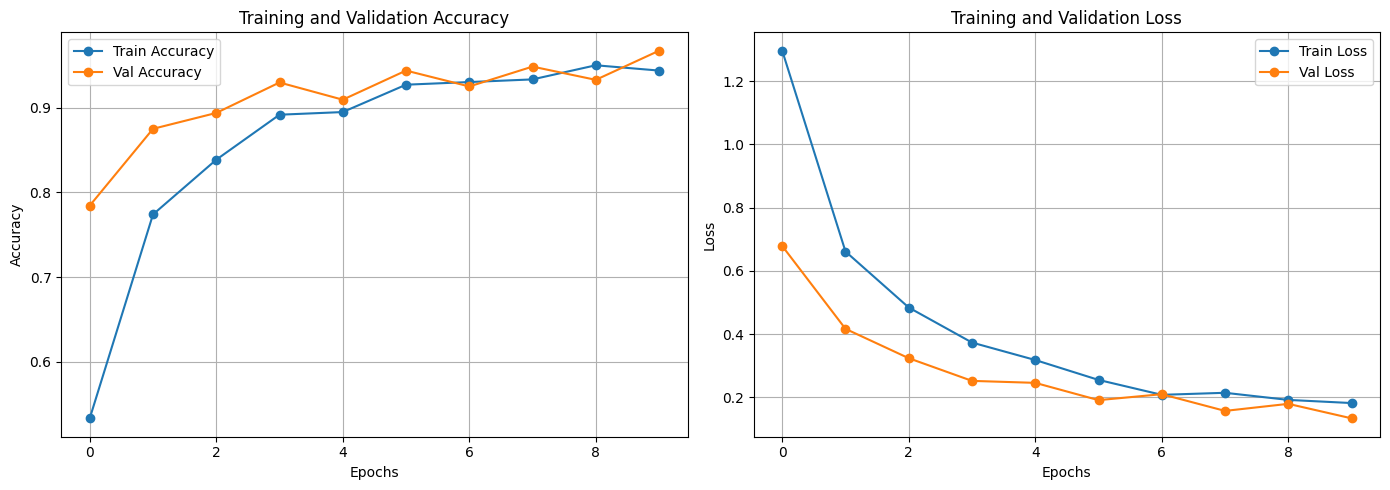

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Val Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Val Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_generator)

print("\n✅ Final Evaluation Metrics:")
print(f"Validation Accuracy : {val_accuracy * 100:.2f}%")
print(f"Validation Loss     : {val_loss:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall   : {val_recall:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 188s 10s/step - accuracy: 0.9461 - loss: 0.1824 - precision: 0.9510 - recall: 0.9334

✅ Final Evaluation Metrics:
Validation Accuracy : 96.72%
Validation Loss     : 0.1340
Validation Precision: 0.9714
Validation Recall   : 0.9563


20/20 ━━━━━━━━━━━━━━━━━━━━ 190s 9s/step


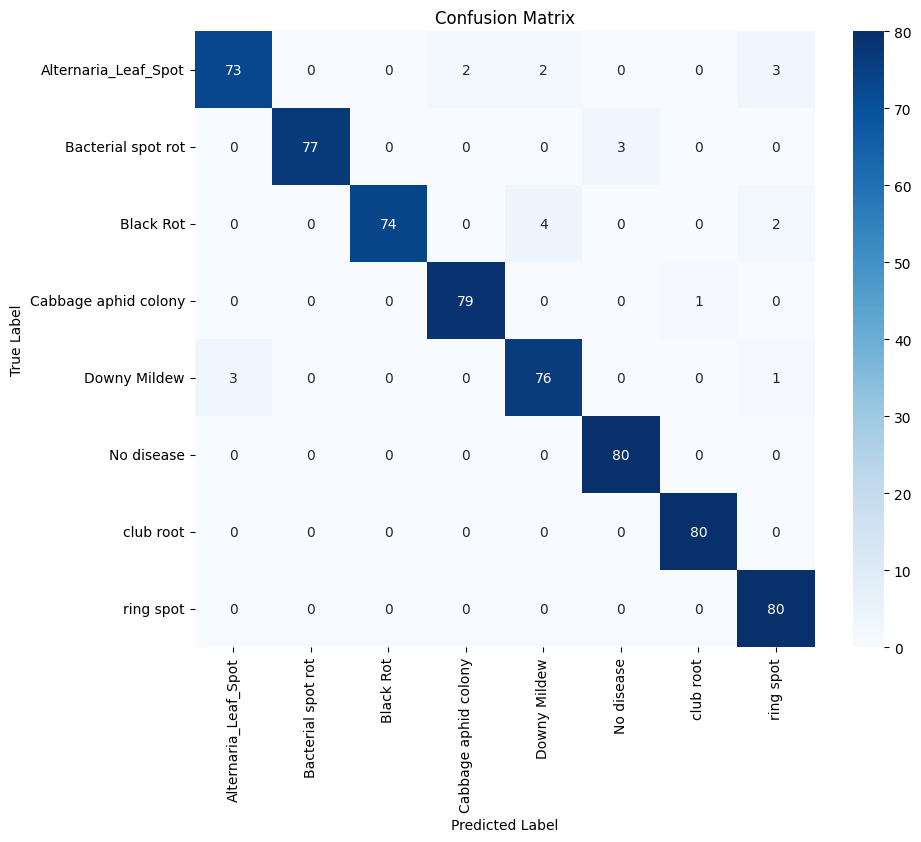


🧾 Classification Report:
                      precision    recall  f1-score   support

Alternaria_Leaf_Spot       0.96      0.91      0.94        80
  Bacterial spot rot       1.00      0.96      0.98        80
           Black Rot       1.00      0.93      0.96        80
Cabbage aphid colony       0.98      0.99      0.98        80
        Downy Mildew       0.93      0.95      0.94        80
          No disease       0.96      1.00      0.98        80
           club root       0.99      1.00      0.99        80
           ring spot       0.93      1.00      0.96        80

            accuracy                           0.97       640
           macro avg       0.97      0.97      0.97       640
        weighted avg       0.97      0.97      0.97       640



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:
# Print per-class confusion matrix (TP, FP, FN, TN)
print("\n📊 Per-Class Confusion Matrix Stats:")
for i, class_name in enumerate(class_labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    print(f"\nClass '{class_name}':")
    print(f"  True Positives (TP): {TP}")
    print(f"  False Positives (FP): {FP}")
    print(f"  False Negatives (FN): {FN}")
    print(f"  True Negatives (TN): {TN}")
    print(f"  Confusion Pair (TP FN): {TP} {FN}")



📊 Per-Class Confusion Matrix Stats:

Class 'Alternaria_Leaf_Spot':
  True Positives (TP): 73
  False Positives (FP): 3
  False Negatives (FN): 7
  True Negatives (TN): 557
  Confusion Pair (TP FN): 73 7

Class 'Bacterial spot rot':
  True Positives (TP): 77
  False Positives (FP): 0
  False Negatives (FN): 3
  True Negatives (TN): 560
  Confusion Pair (TP FN): 77 3

Class 'Black Rot':
  True Positives (TP): 74
  False Positives (FP): 0
  False Negatives (FN): 6
  True Negatives (TN): 560
  Confusion Pair (TP FN): 74 6

Class 'Cabbage aphid colony':
  True Positives (TP): 79
  False Positives (FP): 2
  False Negatives (FN): 1
  True Negatives (TN): 558
  Confusion Pair (TP FN): 79 1

Class 'Downy Mildew':
  True Positives (TP): 76
  False Positives (FP): 6
  False Negatives (FN): 4
  True Negatives (TN): 554
  Confusion Pair (TP FN): 76 4

Class 'No disease':
  True Positives (TP): 80
  False Positives (FP): 3
  False Negatives (FN): 0
  True Negatives (TN): 557
  Confusion Pair (TP FN

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Class labels
class_labels = list(val_generator.class_indices.keys())
class_indices_rev = {v: k for k, v in val_generator.class_indices.items()}

# Collect image paths and their true labels
image_paths_labels = []
for cls in os.listdir(val_generator.directory):
    cls_path = os.path.join(val_generator.directory, cls)
    if os.path.isdir(cls_path):
        for fname in os.listdir(cls_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths_labels.append((os.path.join(cls_path, fname), cls))

# Randomly select 10 images
samples = random.sample(image_paths_labels, 10)

# Plotting
plt.figure(figsize=(20, 10))
for idx, (img_path, true_class) in enumerate(samples):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array)
    pred_index = np.argmax(preds)
    pred_class = class_labels[pred_index]
    confidence = preds[0][pred_index] * 100

    # Show image and info
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    color = 'green' if pred_class == true_class else 'red'
    title = f"Actual: {true_class}\nclassify: {pred_class} ({confidence:.1f}%)"
    plt.title(title, fontsize=13, color=color, fontweight='bold')

plt.tight_layout()
plt.suptitle("Actual vs classified Classes for 10 Random Images", fontsize=20, fontweight='bold', y=1.05)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# ✅ Class labels from validation generator
class_labels = list(val_generator.class_indices.keys())

# ✅ Function to predict and visualize one image
def predict_single_image(img_path, model, class_labels):
    try:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make prediction
        preds = model.predict(img_array)
        predicted_index = np.argmax(preds)
        predicted_class = class_labels[predicted_index]
        confidence = preds[0][predicted_index]

        # Show image and prediction
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")
        plt.show()

        print(f"✅ Predicted class: {predicted_class}")
        print(f"📊 Confidence: {confidence * 100:.2f}%")

    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


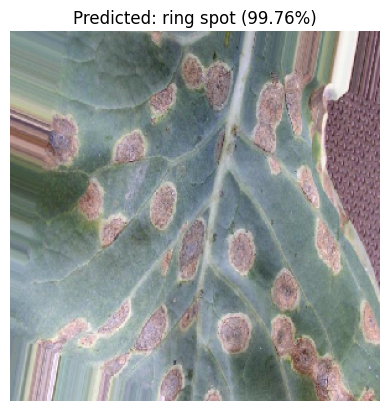

✅ Predicted class: ring spot
📊 Confidence: 99.76%


In [ ]:
# 🔍 Run prediction on a test image
predict_single_image(
    "/content/extracted_files/split_50_50/test/ring spot/orig_83.jpg",  # Update path to your image
    model,
    class_labels
)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# === 1. Final Training & Validation Accuracy from History ===
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(" === Final Accuracy Summary ===")
print(f"Training Accuracy   : {final_train_acc * 100:.2f}%")
print(f"Validation Accuracy : {final_val_acc * 100:.2f}%")

# === 2. Predictions on Test (Validation) Set ===
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# === 3. Final Metrics ===
test_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n === Final Test Evaluation Metrics ===")
print(f"Test Accuracy       : {test_accuracy * 100:.2f}%")
print(f"Precision           : {precision * 100:.2f}%")
print(f"Recall              : {recall * 100:.2f}%")
print(f"F1 Score            : {f1 * 100:.2f}%")


 === Final Accuracy Summary ===
Training Accuracy   : 94.38%
Validation Accuracy : 96.72%

 === Final Test Evaluation Metrics ===
Test Accuracy       : 96.72%
Precision           : 96.81%
Recall              : 96.72%
F1 Score            : 96.71%


In [ ]:
# Save the trained model
model.save("model4.h5")
print("✅ Model saved as model4.h5")

✅ Model saved as model4.h5
